# Introduction to OpenQAOA: An example workflow

This section provides a walkthrough of a simple example workflow, and is intended as a quick introduction to the functionalities of the OpenQAOA library. More focused examples are provided in other sections of the documentation.

The QAOA workflow can be divided in four simple steps:
- Problem definition: Define your optimization problem here, either by: 
    - using pre-defined problem classes or,
    - supplying your own QUBO
- Model building: 
    - Build the QAOA circuit with the available configurations
    - Choose the backend (device) to run the circuit
    - Choose the properties of the classical optimizer
- Compile model and optimize: 
    - Compile the model by passing the problem defined in step-1
    - Execute `model.optimize()` to run the optimization process
- Extract results
    - Run `model.results` to obtain information on the optimization run 

### Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

### Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

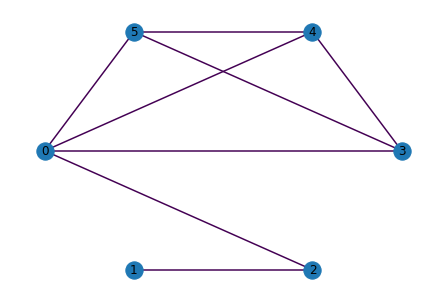

In [7]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [8]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.get_qubo_problem()

In [9]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'n': 6,
 'terms': [[0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [3, 4], [3, 5], [4, 5]],
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


#### Extract the exact solution for a small enough problem



In [10]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -4.0, Solution: ['110100', '110010', '001110', '110001', '001101', '001011']


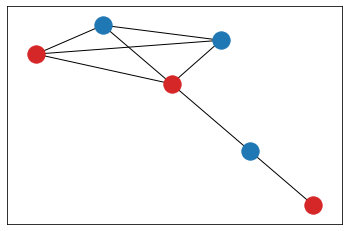

In [11]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

### Step 2: Build the QAOA model
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation stratefy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

In [12]:
# initialize model with default configurations
q = QAOA()

In [13]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=10,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [14]:
# you can print the configurations for a feedback
pprint(q.asdict())

{'backend_properties': {'cvar_alpha': 1, 'init_hadamard': True, 'n_shots': 100},
 'circuit_properties': {'_init_type': 'rand',
                        '_mixer_hamiltonian': 'x',
                        '_p': 2,
                        '_param_type': 'standard',
                        'annealing_time': 0.7,
                        'linear_ramp_time': 0.7,
                        'qubit_register': [],
                        'variational_params_dict': {}},
 'classical_optimizer': {'cost_progress': True,
                         'maxiter': 10,
                         'method': 'nelder-mead',
                         'optimization_progress': True,
                         'optimize': True,
                         'parameter_log': True,
                         'top_k_solutions': 1},
 'device': {'device_location': 'local',
            'device_name': 'qiskit.statevector_simulator'},
 'intialised_w_prob': False,
 'local_simulators': ['qiskit.qasm_simulator',
                      'qiskit.s

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [15]:
q.compile(maxcut_qubo) 

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  qiskit.statevector_simulator  on  local
Using p=2 with standard parameters initialsied as rand
OpenQAOA will optimize using nelder-mead, with up to 10 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 1000


In [16]:
q.optimize()

optimization completed.


### Step 4: Accessing the results

In [17]:
opt_results = q.results

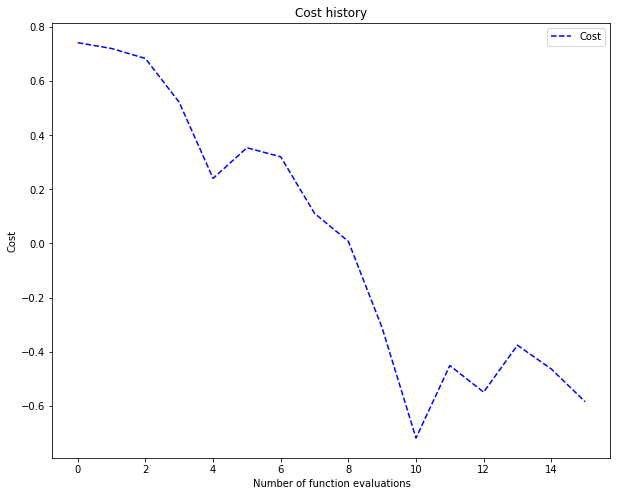

In [18]:
# print the cost history
opt_results.plot_cost()

In [19]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [20]:
pprint(opt_results.optimized)

{'optimized angles': [2.759321522005525,
                      1.1979725891092503,
                      1.6109842920685011,
                      3.3592891278559556],
 'optimized cost': -0.7191345907598119,
 'optimized measurement outcomes': array([-0.00125133-0.02158149j,  0.06649739-0.08166959j,
       -0.01934681+0.02338329j, -0.10116602+0.02203808j,
       -0.01821049-0.02788193j,  0.11933627-0.0782418j ,
        0.0230242 +0.02362006j, -0.07607446+0.11438809j,
        0.07440654+0.09915637j,  0.00911768+0.11879051j,
       -0.01974701-0.13516369j,  0.06452052-0.08602382j,
        0.02871509+0.09029637j, -0.05809915+0.17807633j,
       -0.07891467-0.0732908j , -0.01428876-0.17166776j,
        0.07440654+0.09915637j,  0.00911768+0.11879051j,
       -0.01974701-0.13516369j,  0.06452052-0.08602382j,
        0.02871509+0.09029637j, -0.05809915+0.17807633j,
       -0.07891467-0.0732908j , -0.01428876-0.17166776j,
       -0.01428876-0.17166776j, -0.07891467-0.0732908j ,
       -0.058099

In [24]:
variational_params = q.optimizer.variational_params

In [46]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['optimized angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                               »
q0_0: ┤ H ├─■────────────────────■────────────────────────────────────────»
      ├───┤ │                    │                                        »
q0_1: ┤ H ├─┼────────────────────┼────────────────────■───────────────────»
      ├───┤ │ZZ(3.221968584137)  │                    │ZZ(3.221968584137) »
q0_2: ┤ H ├─■────────────────────┼────────────────────■───────────────────»
      ├───┤                      │ZZ(3.221968584137)                      »
q0_3: ┤ H ├──────────────────────■────────────────────────────────────────»
      ├───┤                                                               »
q0_4: ┤ H ├───────────────────────────────────────────────────────────────»
      ├───┤                                                               »
q0_5: ┤ H ├───────────────────────────────────────────────────────────────»
      └───┘                                                               »
«                                                                         »
«q0_0: ─■─────────────────────────────────────────────■───────────────────»
«       │                   ┌───────────────────────┐ │                   »
«q0_1: ─┼───────────────────┤ Rx(-5.51864304401105) ├─┼───────────────────»
«       │                   ├───────────────────────┤ │                   »
«q0_2: ─┼───────────────────┤ Rx(-5.51864304401105) ├─┼───────────────────»
«       │                   └───────────────────────┘ │                   »
«q0_3: ─┼──────────────────────■──────────────────────┼───────────────────»
«       │ZZ(3.221968584137)    │ZZ(3.221968584137)    │                   »
«q0_4: ─■──────────────────────■──────────────────────┼───────────────────»
«                                                     │ZZ(3.221968584137) »
«q0_5: ───────────────────────────────────────────────■───────────────────»
«                                                                         »
«      ┌───────────────────────┐                         »
«q0_0: ┤ Rx(-5.51864304401105) ├──■──────────────────────»
«      └───────────────────────┘  │                      »
«q0_1: ───────────────────────────┼──────────────────────»
«                                 │ZZ(6.71857825571191)  »
«q0_2: ───────────────────────────■──────────────────────»
«                               ┌───────────────────────┐»
«q0_3: ───■─────────────────────┤ Rx(-5.51864304401105) ├»
«         │                     └───────────────────────┘»
«q0_4: ───┼────────────────────────■─────────────────────»
«         │ZZ(3.221968584137)      │ZZ(3.221968584137)   »
«q0_5: ───■────────────────────────■─────────────────────»
«                                                        »
«                                                                             »
«q0_0: ──■──────────────────────────────────────────────■─────────────────────»
«        │                                              │                     »
«q0_1: ──┼───────────────────────■──────────────────────┼─────────────────────»
«        │                       │ZZ(6.71857825571191)  │                     »
«q0_2: ──┼───────────────────────■──────────────────────┼─────────────────────»
«        │ZZ(6.71857825571191)                          │                     »
«q0_3: ──■──────────────────────────────────────────────┼─────────────────────»
«      ┌───────────────────────┐                        │ZZ(6.71857825571191) »
«q0_4: ┤ Rx(-5.51864304401105) ├────────────────────────■─────────────────────»
«      ├───────────────────────┤                                              »
«q0_5: ┤ Rx(-5.51864304401105) ├──────────────────────────────────────────────»
«      └───────────────────────┘                                              »
«                                                     ┌──────────────────────┐»
«q0_0: ─────────────────────────■─────────────────────┤ Rx(-2.3959451782185) ├»
«      ┌──────────────────────┐ │                     └────────